In [1]:
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pattern3

# Libraries for classical machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Libraries for deep learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Embedding, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

# Libraries for topic modeling
from pprint import pprint
import gensim, spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess #lemmatize
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
import pyLDAvis.gensim

%matplotlib inline

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ModuleNotFoundError: No module named 'pattern3'

<h1>Load Data </h1>

In [ ]:
# Read the clean dataset
reviews = pd.read_csv('clean_train2.csv')

In [ ]:
# View the first 5 rows of our dataset
reviews

,review_text,content_stem,review_rating,target
0,"this app, last month until today always say th...",last month today alway say avail ship option t...,1,1
1,bigla na lang akong na restrict. so disappoint...,bigla akong restrict disappoint,1,1
2,excellent service,excel servic,5,0
3,all my needed items nasa shopee na,need nasa,5,0
4,"im happy to have app shopee no.1 i'd like,, ni...",im happi like nice choic order anyth need got ...,5,0
...,...,...,...,...
3492,i'll we try..,tri,5,0
3493,super looooooooooooooooooooooodiiiiiiiiiiiiiii...,super looooooooooooooooooooooodiiiiiiiiiiiiiii...,3,1
3494,its good,good,5,0
3495,too much spam on my chat from different store....,much spam chat differ store block store follow...,1,1


In [ ]:
# 3497 documents in our dataset
reviews.shape

(3497, 4)

In [ ]:
reviews['review_text'] = reviews['review_text'].astype(str)

In [ ]:
# Check the data types
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3497 entries, 0 to 3496
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   review_text    3497 non-null   object
 1   content_stem   3496 non-null   object
 2   review_rating  3497 non-null   int64 
 3   target         3497 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 109.4+ KB


In [ ]:
# Establish our baseline score
reviews['target'].value_counts(normalize=True)

target
0    0.77495
1    0.22505
Name: proportion, dtype: float64

Given that the majority class is class 0, our baseline score is an accuracy of **0.77**. The baseline score will serve as a point of comparison when evaluating our models.

<h1>Pre-modeling</h1>

In [ ]:
X = reviews['content_stem']
y = reviews['target']

In [ ]:
# Perform train test split so that we can train, score and tune our models' hyperparameters
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X_train.shape

(2797,)

In [ ]:
X_val.shape

(700,)

In [ ]:
y_train.value_counts(normalize=True)

target
0    0.775116
1    0.224884
Name: proportion, dtype: float64

In [ ]:
y_val.value_counts(normalize=True)

target
0    0.774286
1    0.225714
Name: proportion, dtype: float64

In [ ]:
# Assuming X_train and X_val are your training and validation sets
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_val = X_val.dropna()
y_val = y_val.loc[X_val.index]


In [ ]:
X_train = X_train.fillna('')
X_val = X_val.fillna('')

In [ ]:
# Use count vectorizer to check how many unique words there are
cvec = CountVectorizer(stop_words='english')
cvec_df = pd.DataFrame(cvec.fit_transform(X_train).todense(), columns=cvec.get_feature_names())
cvec_df.shape

MemoryError: Unable to allocate 134. GiB for an array with shape (293999, 61341) and data type int64

In [ ]:
# Write a function that takes in the actual y value and model predictions,
# and prints out the confusion matrix and classification report
# Dataset: Validation or test set

def cmat(actual_y, predictions, dataset):

    # Create a classification report
    print('Classification report for', dataset)
    print(classification_report(actual_y, predictions))
    print('')

    # Create a confusion matrix
    cm = confusion_matrix(actual_y, predictions)
    cm_df = pd.DataFrame(cm, columns=['Predicted Positive Review','Predicted Negative Review'], index=['Actual Positive Review', 'Actual Negative Review'])
    print('Confusion matrix for', dataset)
    print(cm_df)

<h1>Modeling</h1>
Classical machine learning will be used for sentiment analysis. The production model will be selected based on accuracy and recall on the validation set.

<h2>Classical Machine Learning</h2>

Bag of Words (BoW) representation will be used to extract features from the text.

CountVectorizer - tokenizes and counts the word occurrences in our corpus.
TF-IDF - tells us which words are important to one document

After vectorizing, we will fit a Logistic Regression, Naive Bayes and Support Vector Machine on the training data and evaluate the models' performance on the validation set.

<h3> Count Vectorizer & Logistic Regression </h3>

In [ ]:
# Create a pipeline with Count Vectorizer and Logistic Regression
pipe_cvec_lr = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('lr', LogisticRegression(random_state=42))
])

# Search over the following values of hyperparameters:
pipe_cvec_lr_params = {
    'cvec__max_features': [300], #100,200
    'cvec__min_df': [2,3],
    'cvec__max_df': [.9,.95],
    'cvec__ngram_range':[(1,1),(1,2)],
    'lr__penalty': ['l2'],
    'lr__C': [.01,.1]
}

# Instantiate GridSearchCV
gs_cvec_lr = GridSearchCV(pipe_cvec_lr, # Objects to optimise
                          param_grid = pipe_cvec_lr_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_cvec_lr.fit(X_train, y_train)

# Generate predictions on validation set
cvec_lr_pred = gs_cvec_lr.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_cvec_lr.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_cvec_lr.best_score_)
print('Training score:', gs_cvec_lr.score(X_train, y_train))
print('Validation score:', gs_cvec_lr.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, cvec_lr_pred, 'validation set')

Best parameters:  {'cvec__max_df': 0.9, 'cvec__max_features': 300, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'lr__C': 0.1, 'lr__penalty': 'l2'}
Best CV score:  0.8387544802867384
Training score: 0.85305684662138
Validation score: 0.8383404864091559

Classification report for validation set
              precision    recall  f1-score   support

           0       0.83      0.99      0.90       542
           1       0.88      0.32      0.47       157

    accuracy                           0.84       699
   macro avg       0.86      0.66      0.69       699
weighted avg       0.84      0.84      0.81       699


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        535                          7
Actual Negative Review                        106                         51


<h3> TF-IDF & Logistic Regression </h3>

In [ ]:
# Create a pipeline with TF-IDF and Logistic Regression
pipe_tvec_lr = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('lr', LogisticRegression(random_state=42))
])

# Search over the following values of hyperparameters:
pipe_tvec_lr_params = {
    'tvec__max_features': [300], #100,200
    'tvec__min_df': [2,3], #2,3
    'tvec__max_df': [.9,.95],
#     'tvec__ngram_range':[(1,1),(1,2)],
    'lr__penalty': ['l2'],
    'lr__C': [.1, 1] #.1, .01
}

# Instantiate GridSearchCV
gs_tvec_lr = GridSearchCV(pipe_tvec_lr, # Objects to optimise
                          param_grid = pipe_tvec_lr_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_tvec_lr.fit(X_train, y_train)

# Generate predictions on validation set
tvec_lr_pred = gs_tvec_lr.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_tvec_lr.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_tvec_lr.best_score_)
print('Training score:', gs_tvec_lr.score(X_train, y_train))
print('Validation score:', gs_tvec_lr.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, tvec_lr_pred, 'validation set')

Best parameters:  {'lr__C': 1, 'lr__penalty': 'l2', 'tvec__max_df': 0.9, 'tvec__max_features': 300, 'tvec__min_df': 2}
Best CV score:  0.872731694828469
Training score: 0.9020378977475867
Validation score: 0.8583690987124464

Classification report for validation set
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       542
           1       0.82      0.48      0.60       157

    accuracy                           0.86       699
   macro avg       0.84      0.72      0.76       699
weighted avg       0.85      0.86      0.84       699


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        525                         17
Actual Negative Review                         82                         75


<h3> Count Vectorizer & Naive Bayes </h3>

In [ ]:
# Create a pipeline with Count Vectorizer and Naive Bayes
pipe_cvec_nb = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters:
pipe_cvec_nb_params = {
    'cvec__max_features': [500], #200
    'cvec__min_df': [2,3],
    'cvec__max_df': [.9,.95],
#     'cvec__ngram_range':[(1,1),(1,2)],
}

# Instantiate GridSearchCV
gs_cvec_nb = GridSearchCV(pipe_cvec_nb, # Objects to optimise
                          param_grid = pipe_cvec_nb_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_cvec_nb.fit(X_train, y_train)

# Generate predictions on validation set
cvec_nb_pred = gs_cvec_nb.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_cvec_nb.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_cvec_nb.best_score_)
print('Training score:', gs_cvec_nb.score(X_train, y_train))
print('Validation score:', gs_cvec_nb.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, cvec_nb_pred, 'validation set')

Best parameters:  {'cvec__max_df': 0.9, 'cvec__max_features': 500, 'cvec__min_df': 3}
Best CV score:  0.8877329749103943
Training score: 0.9084733643189131
Validation score: 0.8783977110157367

Classification report for validation set
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       542
           1       0.78      0.64      0.70       157

    accuracy                           0.88       699
   macro avg       0.84      0.79      0.81       699
weighted avg       0.87      0.88      0.87       699


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        513                         29
Actual Negative Review                         56                        101



<h3> TF-IDF & Naive Bayes </h3>

In [ ]:
# Create a pipeline with TF-IDF and Naive Bayes
pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters:
pipe_tvec_nb_params = {
    'tvec__max_features': [500], #200
    'tvec__min_df': [2,3], #
    'tvec__max_df': [.9,.95],
    'tvec__ngram_range':[(1,1),(1,2)],
}

# Instantiate GridSearchCV
gs_tvec_nb = GridSearchCV(pipe_tvec_nb, # Objects to optimise
                          param_grid = pipe_tvec_nb_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_tvec_nb.fit(X_train, y_train)

# Generate predictions on validation set
tvec_nb_pred = gs_tvec_nb.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_tvec_nb.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_tvec_nb.best_score_)
print('Training score:', gs_tvec_nb.score(X_train, y_train))
print('Validation score:', gs_tvec_nb.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, tvec_nb_pred, 'validation set')

Best parameters:  {'tvec__max_df': 0.9, 'tvec__max_features': 500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}
Best CV score:  0.8809395801331286
Training score: 0.9077583124776546
Validation score: 0.871244635193133

Classification report for validation set
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       542
           1       0.83      0.54      0.65       157

    accuracy                           0.87       699
   macro avg       0.85      0.75      0.79       699
weighted avg       0.87      0.87      0.86       699


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        525                         17
Actual Negative Review                         73                         84



<h3> Count Vectorizer & SVC </h3>

In [ ]:
# Create a pipeline with Count Vectorizer and SVC
pipe_cvec_svc = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('svc', SVC(random_state=42))
])

# Search over the following values of hyperparameters:
pipe_cvec_svc_params = {
    'cvec__max_features': [300], #200,500
    'cvec__min_df': [2,3],
    'cvec__max_df': [.9,.95],
#     'cvec__ngram_range':[(1,1),(1,2)],
    'svc__kernel': ['linear'], #'poly', 'rbf'
#     'svc__degree': [3],
    'svc__C': [.1]
}

# Instantiate GridSearchCV
gs_cvec_svc = GridSearchCV(pipe_cvec_svc, # Objects to optimise
                          param_grid = pipe_cvec_svc_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_cvec_svc.fit(X_train, y_train)

# Generate predictions on validation set
cvec_svc_pred = gs_cvec_svc.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_cvec_svc.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_cvec_svc.best_score_)
print('Training score:', gs_cvec_svc.score(X_train, y_train))
print('Validation score:', gs_cvec_svc.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, cvec_svc_pred, 'validation set')

Best parameters:  {'cvec__max_df': 0.9, 'cvec__max_features': 300, 'cvec__min_df': 2, 'svc__C': 0.1, 'svc__kernel': 'linear'}
Best CV score:  0.8516295442908346
Training score: 0.8723632463353593
Validation score: 0.8426323319027181

Classification report for validation set
              precision    recall  f1-score   support

           0       0.84      0.98      0.91       542
           1       0.86      0.36      0.50       157

    accuracy                           0.84       699
   macro avg       0.85      0.67      0.71       699
weighted avg       0.85      0.84      0.82       699


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        533                          9
Actual Negative Review                        101                         56



<h3> TF-IDF & SVC </h3>

In [ ]:
# Create a pipeline with TF-IDF Vectorizer and SVC
pipe_tvec_svc = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('svc', SVC(probability=True, random_state=42))
])

# Search over the following values of hyperparameters:
pipe_tvec_svc_params = {
    'tvec__max_features': [800], #200,500
    'tvec__min_df': [2,3],
    'tvec__max_df': [.9,.95],
#     'tvec__ngram_range':[(1,1),(1,2)],
    'svc__kernel': ['linear'], #'poly', 'rbf'
#     'svc__degree': [3],
    'svc__C': [.1] # .01
}

# Instantiate GridSearchCV
gs_tvec_svc = GridSearchCV(pipe_tvec_svc, # Objects to optimise
                          param_grid = pipe_tvec_svc_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_tvec_svc.fit(X_train, y_train)

# Generate predictions on validation set
tvec_svc_pred = gs_tvec_svc.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_tvec_svc.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_tvec_svc.best_score_)
print('Training score:', gs_tvec_svc.score(X_train, y_train))
print('Validation score:', gs_tvec_svc.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, tvec_svc_pred, 'validation set')

Best parameters:  {'svc__C': 0.1, 'svc__kernel': 'linear', 'tvec__max_df': 0.9, 'tvec__max_features': 800, 'tvec__min_df': 3}
Best CV score:  0.7815501792114695
Training score: 0.7894172327493744
Validation score: 0.7811158798283262

Classification report for validation set
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       542
           1       0.83      0.03      0.06       157

    accuracy                           0.78       699
   macro avg       0.81      0.52      0.47       699
weighted avg       0.79      0.78      0.69       699


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        541                          1
Actual Negative Review                        152                          5


In [ ]:
# Instantiate the Voting Classifier with TF-IDF Logistic Regression and TF-IDF Naïve Bayes
voting_clf = VotingClassifier(
    estimators=[('tvec_lr', gs_tvec_lr),
                ('tvec_nb', gs_tvec_nb)],
    voting='soft',
    weights=[1,2]
)

# Fit model on to training data
voting_clf.fit(X_train, y_train)

# Generate predictions on validation set
voting_pred = voting_clf.predict(X_val)

# Print accuracy scores
print('Training score:', voting_clf.score(X_train, y_train))
print('Validation score:', voting_clf.score(X_val, y_val))
print('')

# Print classification report and confusion matrix
cmat(y_val, voting_pred, 'validation set')

Training score: 0.9081158383982839
Validation score: 0.8683834048640916

Classification report for validation set
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       542
           1       0.84      0.51      0.63       157

    accuracy                           0.87       699
   macro avg       0.86      0.74      0.78       699
weighted avg       0.87      0.87      0.86       699


Confusion matrix for validation set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        527                         15
Actual Negative Review                         77                         80


<h2> <b>Production Model's Most Predictive Words </b><h2>


<h3> <b>Logistic Regression </b><h3>

In [ ]:
# Save the words obtained from TF-IDF vectorizer in a dataframe
lr_coef = pd.DataFrame(gs_tvec_lr.best_estimator_.named_steps['tvec'].get_feature_names_out(), columns=['word'])

In [ ]:
# Use np.exp() to exponentiate the coefficients
lr_coef['exp_coef'] = np.exp(gs_tvec_lr.best_estimator_.named_steps['lr'].coef_[0])

In [ ]:
# Top words related to positive sentiment (class 0)
pos_sent_lr = lr_coef.sort_values(by='exp_coef').head(10)

# Top words related to negative sentiment (class 1)
neg_sent_lr = lr_coef.sort_values(by='exp_coef').tail(10)

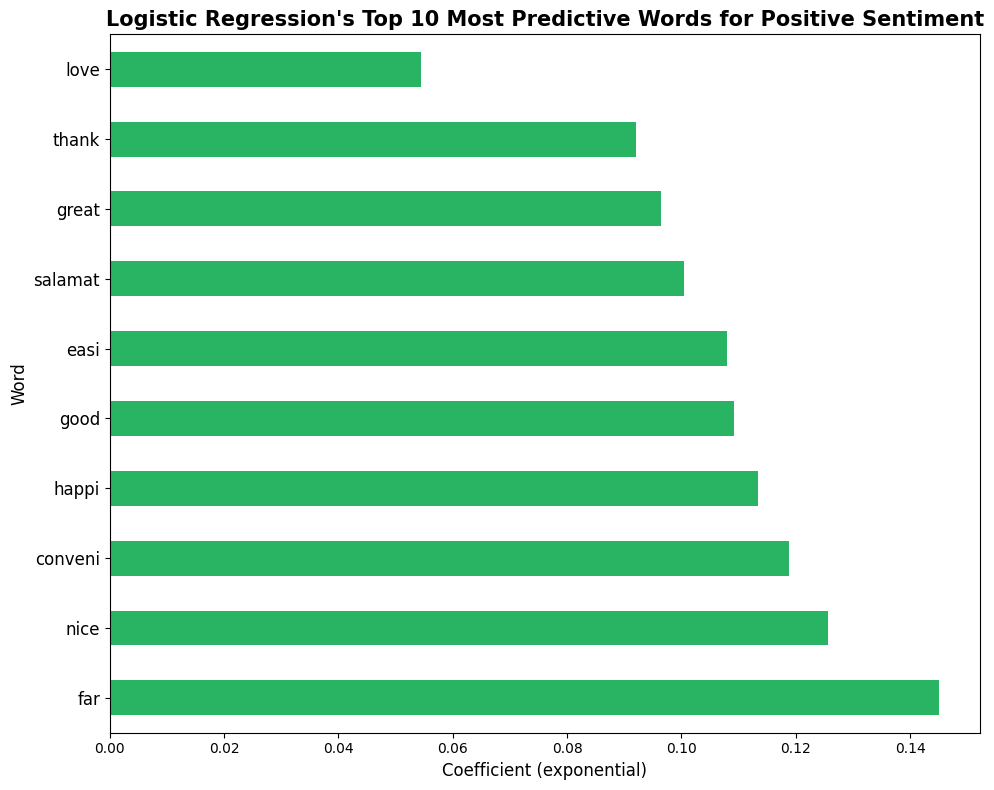

In [ ]:
pos_sent_lr.sort_values('exp_coef', ascending=False).plot(x='word', y='exp_coef', kind='barh', figsize=(10,8), legend=None, color='#28B463')
plt.title("Logistic Regression's Top 10 Most Predictive Words for Positive Sentiment", size=15, weight='bold')
plt.yticks(size=12)
plt.ylabel('Word', size=12)
plt.xlabel("Coefficient (exponential)", size=12)
plt.tight_layout();

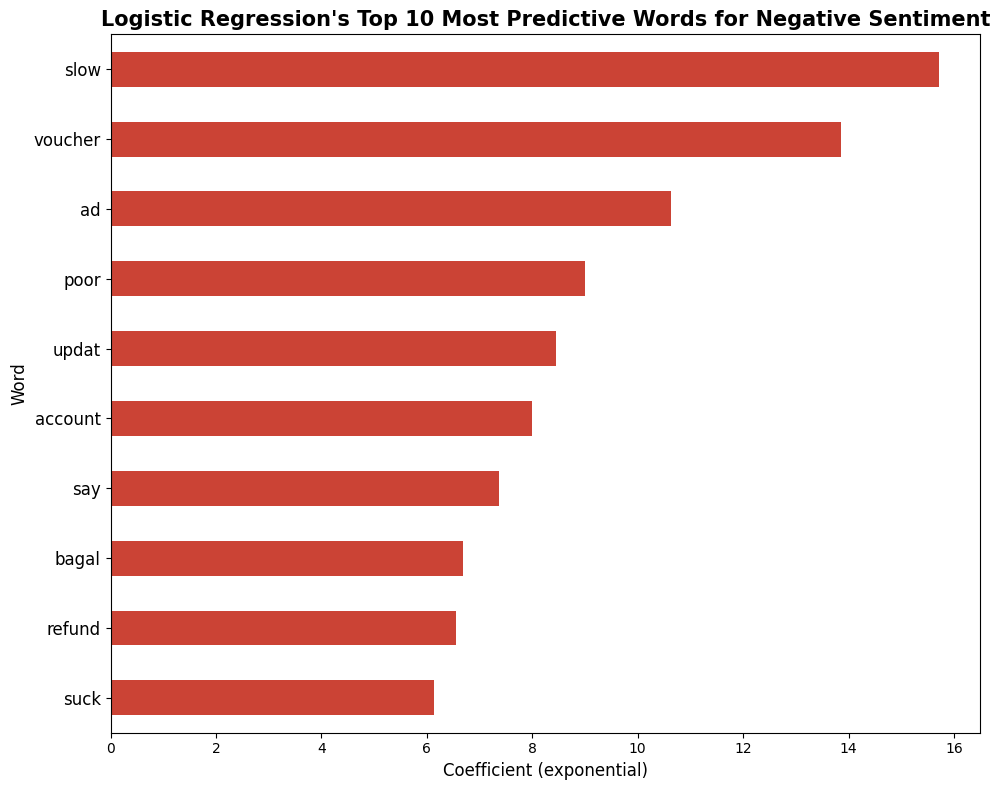

In [ ]:
neg_sent_lr.plot(x='word', y='exp_coef', kind='barh', figsize=(10,8), legend=None, color='#CB4335')
plt.title("Logistic Regression's Top 10 Most Predictive Words for Negative Sentiment", size=15, weight='bold')
plt.yticks(size=12)
plt.ylabel('Word', size=12)
plt.xlabel("Coefficient (exponential)", size=12)
plt.tight_layout();

<h2><b>Naive Bayes</b></h2>

In [ ]:
# Save the words obtained from TF-IDF vectorizer in a dataframe
feature_names = gs_tvec_nb.best_estimator_.named_steps['tvec'].get_feature_names_out()

In [ ]:
nb_coef = pd.DataFrame(feature_names, columns=['word'])
nb_coef['log_prob_class_0'] = gs_tvec_nb.best_estimator_.named_steps['nb'].feature_log_prob_[0]
nb_coef['log_prob_class_1'] = gs_tvec_nb.best_estimator_.named_steps['nb'].feature_log_prob_[1]

In [ ]:
# Top words related to positive sentiment (class 0)
pos_sent_nb = nb_coef.sort_values(by='log_prob_class_0').head(10)

# Top words related to negative sentiment (class 1)
neg_sent_nb = nb_coef.sort_values(by='log_prob_class_1').head(10)

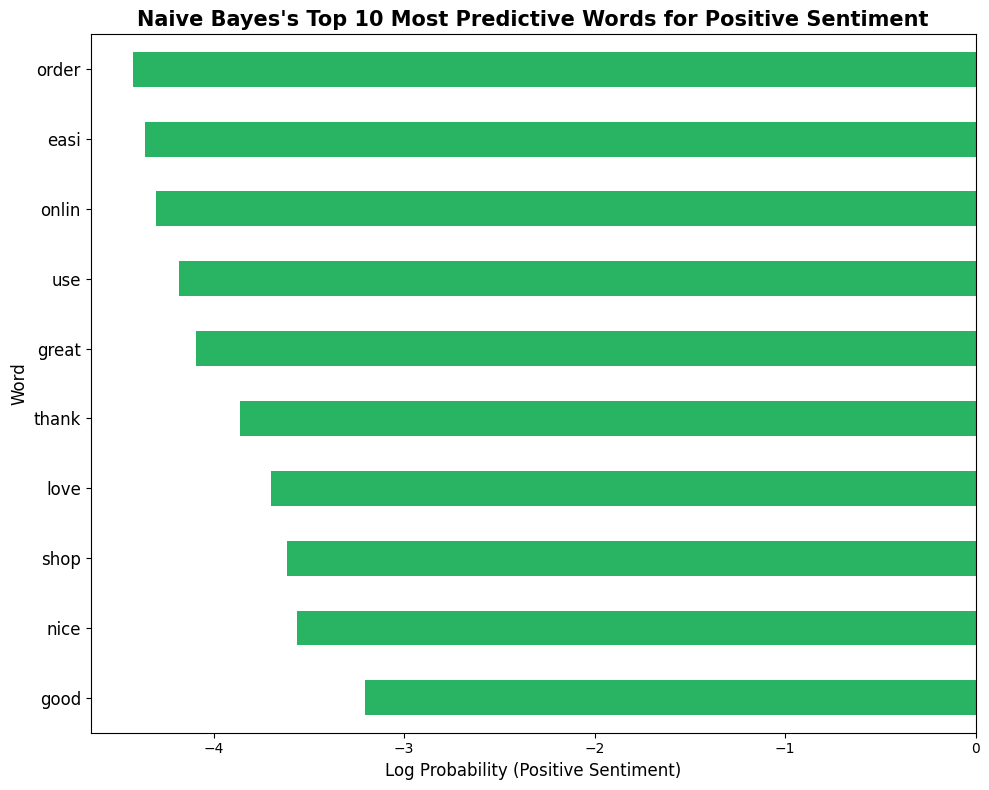

In [ ]:
# Save the words obtained from TF-IDF vectorizer in a dataframe
nb_coef = pd.DataFrame(gs_tvec_nb.best_estimator_.named_steps['tvec'].get_feature_names_out(), columns=['word'])

# Coefficients (feature log probabilities)
nb_coef['log_prob_class_0'] = gs_tvec_nb.best_estimator_.named_steps['nb'].feature_log_prob_[0]
nb_coef['log_prob_class_1'] = gs_tvec_nb.best_estimator_.named_steps['nb'].feature_log_prob_[1]

# Top words related to positive sentiment (class 0)
pos_sent_nb = nb_coef.sort_values(by='log_prob_class_0', ascending=False).head(10)

# Top words related to negative sentiment (class 1)
neg_sent_nb = nb_coef.sort_values(by='log_prob_class_1', ascending=False).head(10)

pos_sent_nb.sort_values('log_prob_class_0', ascending=False).plot(
    x='word', y='log_prob_class_0', kind='barh', figsize=(10, 8),
    legend=None, color='#28B463'
)
plt.title("Naive Bayes's Top 10 Most Predictive Words for Positive Sentiment", size=15, weight='bold')
plt.yticks(size=12)
plt.ylabel('Word', size=12)
plt.xlabel("Log Probability (Positive Sentiment)", size=12)
plt.tight_layout()
plt.show()


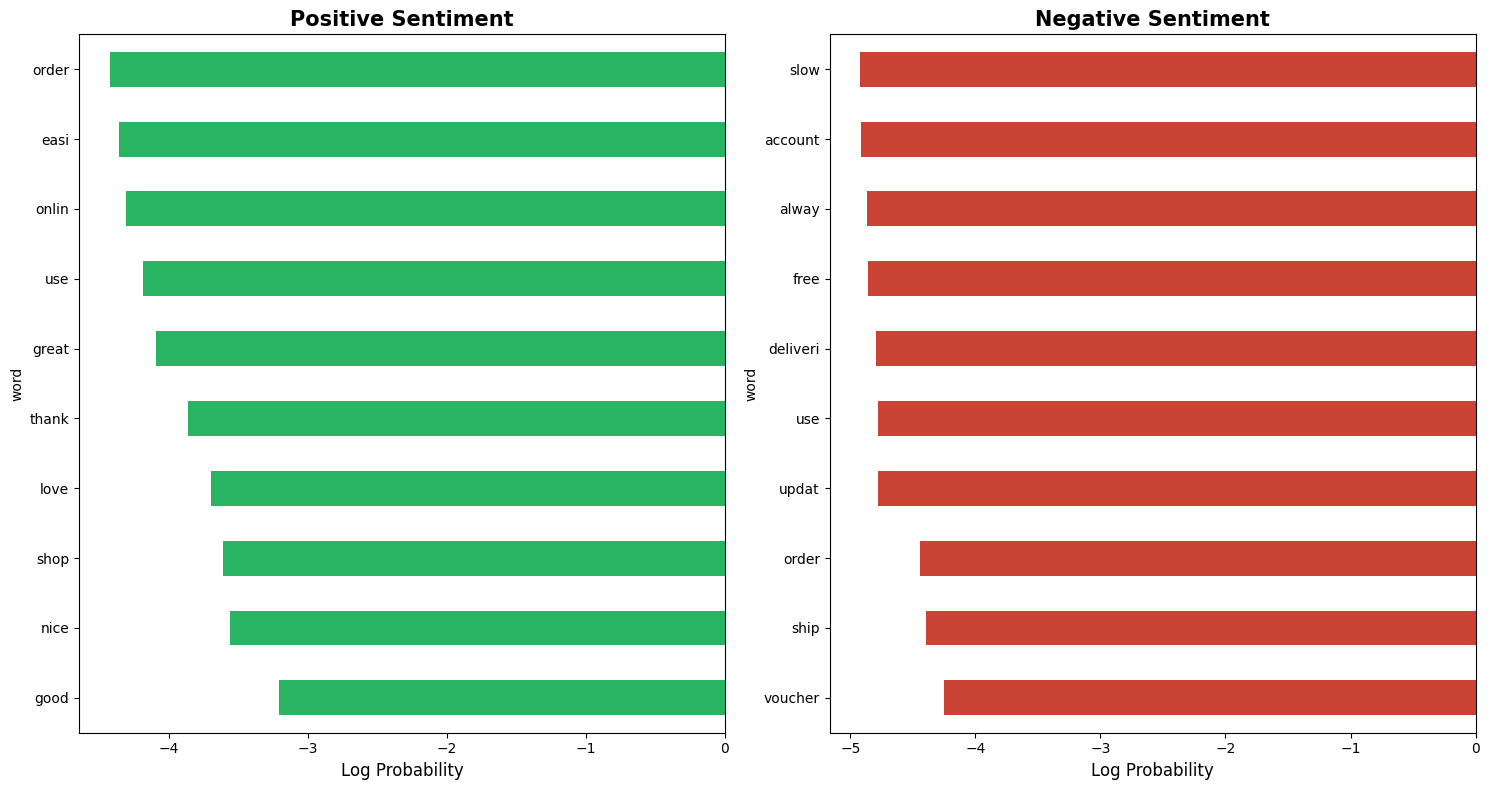

In [ ]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Plot for positive sentiment
pos_sent_nb.sort_values('log_prob_class_0', ascending=False).plot(
    x='word', y='log_prob_class_0', kind='barh', ax=axs[0],
    legend=None, color='#28B463'
)
axs[0].set_title("Positive Sentiment", size=15, weight='bold')
axs[0].set_yticklabels(pos_sent_nb['word'])  # Corrected line
axs[0].set_xlabel("Log Probability", size=12)

# Plot for negative sentiment
neg_sent_nb.sort_values('log_prob_class_1', ascending=False).plot(
    x='word', y='log_prob_class_1', kind='barh', ax=axs[1],
    legend=None, color='#CB4335'
)
axs[1].set_title("Negative Sentiment", size=15, weight='bold')
axs[1].set_yticklabels(neg_sent_nb['word'])  # Corrected line
axs[1].set_xlabel("Log Probability", size=12)

plt.tight_layout()
plt.show()


<h1><b>Misclassified Reviews on Validation Set</b></h1>

In [ ]:
# Create a dataframe for only the validation data
val_df = reviews.loc[y_val.index, :]

# Insert a column for predictions
val_df['pred'] = tvec_nb_pred

In [ ]:
# Create a column to indicate if the review was correctly predicted
val_df['correctly_classified'] = (val_df['pred'] == val_df['target'])

In [ ]:
# 102 misclassified reviews
val_df[val_df['correctly_classified']==0].shape

(90, 6)

In [ ]:
# Display the full width so that we can read the misclassified reviews
pd.set_option('display.max_colwidth', None)

# View the False Positives - Model incorrectly predicts these as negative sentiment when they are actually positive sentiment
val_df[(val_df['target']==0) & (val_df['pred']==1)][['review_text','content_stem','review_rating','target','pred']]

,review_text,content_stem,review_rating,target,pred
3135,server error sa akin kainis,server error kaini,5,0,1
1358,i could never go wrong with shopee😊,could never go wrong,4,0,1
2883,"""i wonder y it took almost half day repeating over and over to install you app..i am connected to wifi and the phone has enough memory and i have had done troubleshooting."" #after doing my best to install the app,i found out that shopee is real satisfying..👉👉👉👉👉👉👉👉",wonder took almost half day repeat instal connect wifi phone enough memori done troubleshoot best instal found real satisfi,5,0,1
778,nakakatuwa sa shopee madami pa vouchers :),nakakatuwa madami voucher,5,0,1
1950,"nakaklaibang pala mabudol...,char...😍",nakaklaibang pala mabudol char,5,0,1
3314,i give 4 star because the one of my order didn't deliver to me it was paid via shopee pay i thought the courier wrong that's it thank you,give star one order deliv paid via pay thought courier wrong thank,4,0,1
2663,"the app keeps showing error occured once i am trying to pay the stuff i ordered. how do you suppose i pay for it through the bank when this useless app won't load the pag that contains that information? it just keeps giving me that ""oops error had occured"". really? such hassle, eating up people's time!",keep show error occur tri pay stuff order suppos pay bank useless load pag contain inform keep give oop error occur realli hassl eat peopl time,4,0,1
1491,"this ads keeps on popping on my screen and its disturbing me😡😡 even when i'm playing and i turned on my game mode so no ads, messages and calls will pop when i'm playing or watching😡😡",ad keep pop screen disturb even play turn game mode ad messag call pop play watch,5,0,1
3431,"app is actually good, just a complaint about misinformed promotions. there's always an ad for discounts and free shipping, but every time i check, almost all vouchers are unavailable. most return are easy, offers a wide range of options when paying.",actual good complaint misinform promot alway ad discount free ship everi time check almost voucher unavail return easi offer wide rang option pay,4,0,1
1447,so hard to get free shipping vouchers 😞,hard get free ship voucher,4,0,1


In [ ]:
# View the False Negatives - Model incorrectly predicts these as positive sentiment when they are actually negative sentiment
val_df[(val_df['target']==1) & (val_df['pred']==0)][['review_text','content_stem','review_rating','target','pred']]

,review_text,content_stem,review_rating,target,pred
3410,basta.,basta,1,1,0
2913,why did i didnt get the 100 registration in shopeepay,didnt get registr shopeepay,2,1,0
93,you should never trust shoppe its a scam!!!!! shoppe is the worst app,never trust shopp scam shopp worst,1,1,0
1756,very useful apps,use app,2,1,0
3213,ok nmn na dn..,ok nmn dn,2,1,0
...,...,...,...,...,...
1967,"i really really really love this app! pero nung last update ko nung 8.8 lahat ng games and some hindi na gumana sa phone ko, ewan ko kung bakit nakaka inis lng kc di ako maka kuha ng madaming coins 😭 kc di ako maka pag laro ng games hyssss gstong gsto ko sya kc my small bussiness ako online and sa shopee ako umoorder",realli realli realli love nung last updat nung game gumana phone ewan nakaka ini lng kc maka kuha madam coin kc maka pag laro game hyssss gstong gsto sya kc small bussi onlin umoord,2,1,0
1004,pano po ba mag order kasi diko ma dawn load ang gusto kong item na walet .pls po,pano po ba mag order kasi diko dawn load walet pl po,3,1,0
2939,can improve address detection as well as overall ui,improv address detect well overal ui,3,1,0
1076,ewan,ewan,3,1,0


In [ ]:
# Plot a barplot of the top 20 most frequently occuring words in misclassified reviews

def barplot_tvec(df, pred, title, color):
    words_series = df[(df['correctly_classified']==0) & (df['pred']==pred)]['content_stem']

    # Instantiate TF-IDF Vectorizer
    tvec = TfidfVectorizer(stop_words=['english', 'shop', 'app'])


    # Save the tokens in a dataframe
    tvec_df = pd.DataFrame(tvec.fit_transform(words_series).todense(), columns=tvec.get_feature_names_out())
    sum_words = tvec_df.sum(axis=0) # Sum up the no. of occurences for each word
    top_words = sum_words.sort_values(ascending=False).head(10)
    top_words.sort_values(ascending=True).plot(kind='barh', figsize=(10,8), color=color)

    # Chart aesthetics
    plt.title(title, size=15, weight='bold')
    plt.xlabel('Count', size=12)
    plt.xlim(0,5)
    plt.yticks(size=12)
    plt.tight_layout()

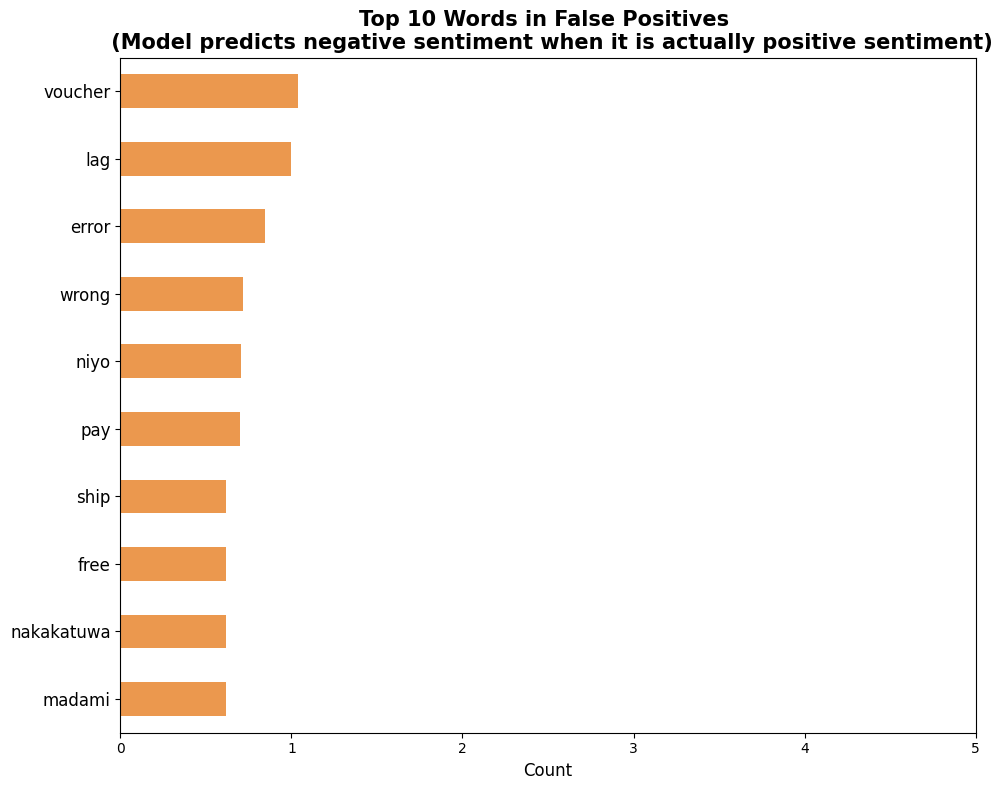

In [ ]:
# Top words seen in False Positives - Model incorrectly predicts these as negative sentiment when they are actually positive sentiment
barplot_tvec(df=val_df,
             pred=1,
             title="Top 10 Words in False Positives \n (Model predicts negative sentiment when it is actually positive sentiment)",
             color='#EB984E')

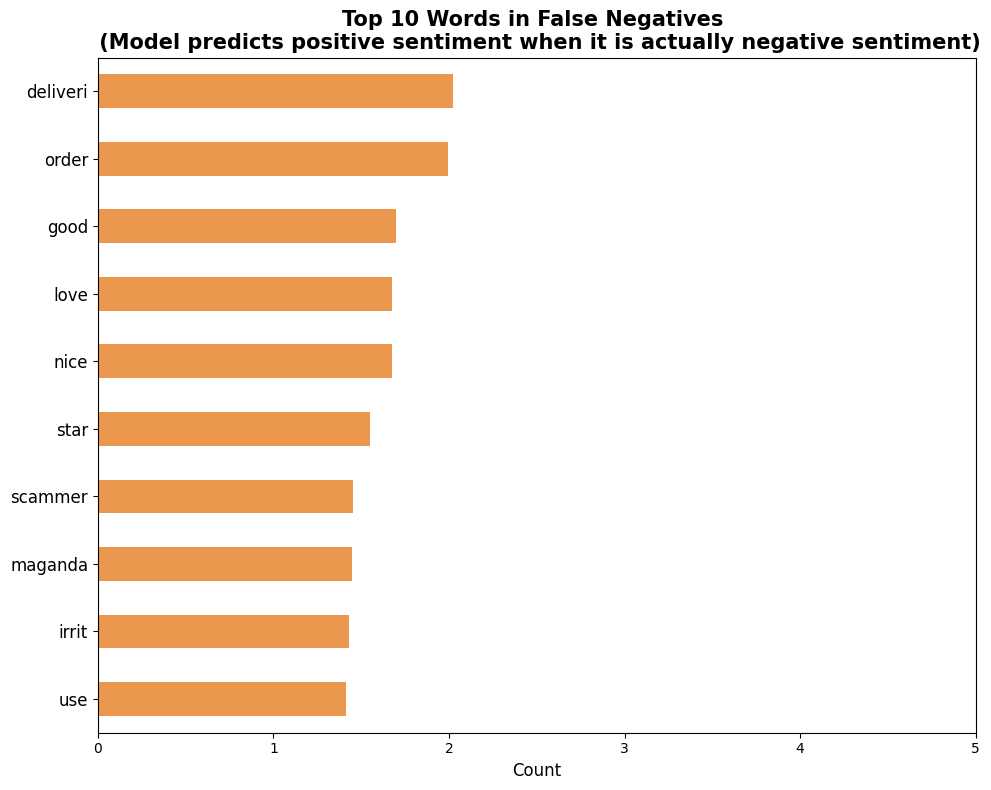

In [ ]:
# Top words seen in False Negatives - Model incorrectly predicts these as postive sentiment when they are actually negative sentiment
barplot_tvec(df=val_df,
             pred=0,
             title="Top 10 Words in False Negatives \n (Model predicts positive sentiment when it is actually negative sentiment)",
             color='#EB984E')

In [ ]:
# False Negatives
fn = val_df[(val_df['correctly_classified']==0) & (val_df['pred']==0)][['review_text','content_stem','review_rating']]

In [ ]:
# Count the number of times the word 'voucher' appears in the review
fn['count_voucher'] = fn['content_stem'].str.count('voucher')

In [ ]:
# Count the number of times the word 'deliveri' appears in the review
fn['count_delivery'] = fn['content_stem'].str.count('deliveri')

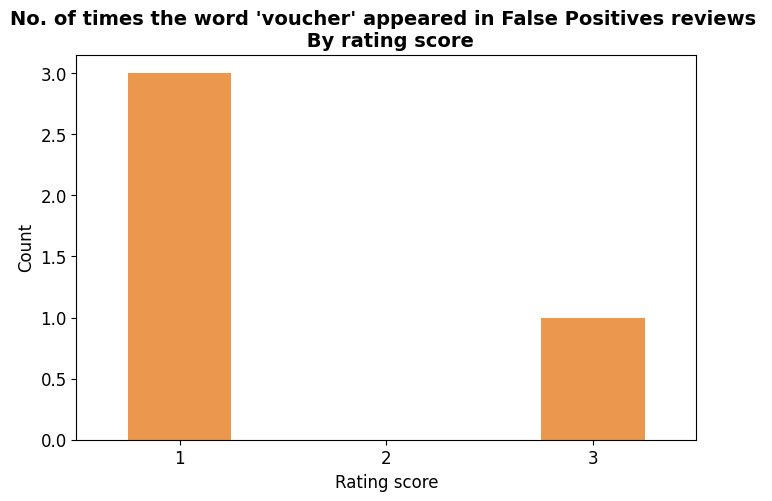

In [ ]:
plt.figure(figsize=(8,5))

# Group False Negative reviews by their ratings and sum up the no. of times the word 'good' was seen
fn.groupby('review_rating')['count_voucher'].sum().plot(kind='bar', color='#EB984E')

plt.title("No. of times the word 'voucher' appeared in False Positives reviews \n By rating score", size=14, weight='bold')
plt.ylabel("Count", size=12)
plt.yticks(size=12)
plt.xlabel("Rating score", size=12)
plt.xticks(size=12, rotation=0);

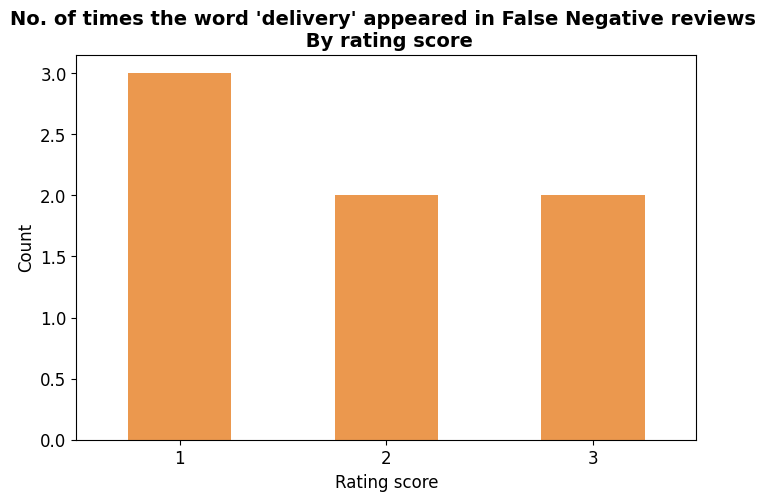

In [ ]:
plt.figure(figsize=(8,5))

# Group False Negative reviews by their ratings and sum up the no. of times the word 'good' was seen
fn.groupby('review_rating')['count_delivery'].sum().plot(kind='bar', color='#EB984E')

plt.title("No. of times the word 'delivery' appeared in False Negative reviews \n By rating score", size=14, weight='bold')
plt.ylabel("Count", size=12)
plt.yticks(size=12)
plt.xlabel("Rating score", size=12)
plt.xticks(size=12, rotation=0);

In [ ]:
pd.set_option('display.max_colwidth', None)

# View only the False Positive that has the words 'good' in it
fn[fn['count_voucher']>0][['review_text','review_rating']]

,review_text,review_rating
2773,voucher sometimes not applied. especially when there are promos like 50 off shipping fee when exceed 199. theres no option for less 50. do something abt this,3
572,"you could select 2 vouchers before , 1 for shipping and 1 for discount/cashbak but now you could only select 1. that feature was what set you apart from lazada and made me choose shoppee more but now with that i may look at other online shops.",1
1762,"i don't like this shopping app that much anymore because of the changes on usage of vouchers and in the farm you shake so fast but gives you the small amount water or coins, your wasting my money time & strength not to so good experience anymore with this online shopping app.",1
3328,1 voucher 1 star,1


In [ ]:
pd.set_option('display.max_colwidth', None)

# View only the False Negatives that has the words 'delivery' in it
fn[fn['count_delivery']>0][['review_text','review_rating']]

,review_text,review_rating
450,the delivery fee is too much than to an item that i bought,1
1780,fast delivery accomodating sellers... okay nman yung shopee wallet lng talaga di ko ngagamit. dami ko issue s paggawa.. gumawa p lo ng isang account then need pala yung shopee pin may laman pero di ko magamit... tsk,3
1092,this app is getting even more terrible. papangit nang papangit na ang shopee. bakit ka nag bago. lalo na and delivery service na shopee xpress. i know sa app lang dapat ang review but i can't help but include their very rude rider.,2
1176,not contented about my order but okey for fast delivery,3
178,p*t*nga *na mo shopee xpress delivery.. panira ka ng december hayup ka.. nakakagigil napaka tagal ng delivery.. nakaka mura talaga,1
1327,not accurate delivery date.,2


<h2><b>Evaluate Production Model on Test Set </b><h2>

In [ ]:
# Read test set into a dataframe
test = pd.read_csv('clean_test2.csv')

In [ ]:
# There are 870 documents in our test set
test.shape

(875, 4)

In [ ]:
# The class representation in our test set looks similar to our training set as we used stratify
test['target'].value_counts(normalize=True)

target
0    0.774857
1    0.225143
Name: proportion, dtype: float64

In [ ]:
# Establish our X and y variables
X_test = test['content_stem']
y_test = test['target']

In [ ]:
# Generate predictions on test set
test_pred = gs_tvec_nb.predict(X_test)

In [ ]:
print('Evaluation metrics for test set')
print('')
print('Accuracy score: ', accuracy_score(y_test, test_pred))
print('')

# Print classification report and confusion matrix
cmat(y_test, test_pred, 'test set')

Evaluation metrics for test set

Accuracy score:  0.8754285714285714

Classification report for test set
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       678
           1       0.83      0.56      0.67       197

    accuracy                           0.88       875
   macro avg       0.86      0.76      0.80       875
weighted avg       0.87      0.88      0.87       875


Confusion matrix for test set
                        Predicted Positive Review  Predicted Negative Review
Actual Positive Review                        655                         23
Actual Negative Review                         86                        111


<h2><b>Misclassified Reviews in the Test Set</b></h2>

In [ ]:
# Generate predictions on the test set
test['pred'] = gs_tvec_nb.predict(X_test)

In [ ]:
# Create a column to indicate if the review was correctly predicted
test['correctly_classified'] = (test['pred'] == test['target'])

In [ ]:
# View the False Positives - Model incorrectly predicts these as negative sentiment when they are actually positive sentiment
test[(test['target']==0) & (test['pred']==1)][['review_text','content_stem','review_rating','target','pred']]

,review_text,content_stem,review_rating,target,pred
16,"ok ang customer service ni shopee, one time i had to refund my payment kxe may sira ung product at ang bilis ng response nila.. same thing nung ang tagal dumating ng item reason ni seller ay walang stock, eh bayad na din ung item, naasikaso nmn agad ng customer service ni shopee para mabalik sa account qo ung payment..",ok custom servic one time refund payment kxe sira ung product bili respons thing nung tagal dumat reason stock eh bayad ung naasikaso nmn agad custom servic mabalik account qo ung payment,5,0,1
24,no more options for cod. free shipping was not true.,option cod free ship true,5,0,1
113,"download ko ulit di ako maka order, lumalabas yung payment option lage kahit meron naman na... bakit kaya?",download ulit maka order lumalaba payment option lage meron,5,0,1
152,admin fee,admin fee,5,0,1
214,"the app is not work,so ineed to update now.",work ine updat,5,0,1
236,sometimes connection is so slow,sometim connect slow,4,0,1
250,"okay rin naman ang shoppe...kaya lang may mga nagbebenta tlga ng mga \nfake... like mga lotions ang soaps...sana matutukan ito ng.mga admin sa \nshoppe, makita sana nila mga comment. ng mga buyers,para mabalaan nila ung \nmga seller,kasi kawawa ung mga bibili eh. tapos fake lang pala ung ibang \nitem na binibenta ng ibang seller. pero kadalasan sa mga orders ko. okay \nnaman. dun lang sa lotions and soaps. may mga fake tlga... tapos pala ung \nibang shiniship ng mga seller na mga gamit or damit mga sira... sana makita \nnyo poh itong mga seller na nagpapadala ng mga siramg items... para mablock \npag uulit parin. thank you in advanced kung matugunan ninyo ang comment ko \n😊😊😊.",okay rin shopp nagbebenta tlga fake like lotion soap sana matutukan admin shopp sana comment buyer mabalaan ung kasi kawawa ung bibili eh tapo fake pala ung ibang binibenta ibang kadalasan order okay dun lotion soap fake tlga tapo pala ung ibang shiniship gamit damit sira sana poh itong nagpapadala siramg mablock pag uulit parin thank advanc matugunan ninyo comment,4,0,1
313,"i don't have problems with this app. with vouchers, you don't have to search coz it's right there to click. most of the shopee products has a minimum shipping of 40php and sometimes it's all free. and you can use the shopeepay to send money without extra charge. all the best in an app! 😊 blessings on you!",problem voucher search coz right click product minimum ship php sometim free use shopeepay send money without extra charg best bless,5,0,1
337,please..,pleas,5,0,1
356,this was edited i gave 5* before because i didnt had a problem about my parcels but now my parcels was stuck in soc3,edit gave didnt problem parcel parcel stuck soc,5,0,1


In [ ]:
# View the False Negatives - Model incorrectly predicts these as positive sentiment when they are actually negative sentiment
test[(test['target']==1) & (test['pred']==0)][['review_text','content_stem','review_rating','target','pred']]

,review_text,content_stem,review_rating,target,pred
20,i don't like how shopee expire (deduct) your coins you earned!,like expir deduct coin earn,3,1,0
27,disabled cod! 🙄🙄🙄,disabl cod,1,1,0
29,disaster in categorization compare to lazada that have lots of option in categories and filters.,disast categor compar lazada lot option categori filter,3,1,0
32,ewwwww,ewwwww,1,1,0
37,xx no not fggyh,xx fggyh,2,1,0
...,...,...,...,...,...
816,"if you're not in a hurry to receive your item, and that item is way cheaper the other shopping platform *cough* lazada, then this will suffice. but if you want a faster delivery, free return and exchange, responsive csr, and easy payment options without fees then this isn't the platform for you. trust me, if the difference is only about a couple of pesos, don't choose this one, better choose the one which has a better assurance that your order will be delivered",hurri receiv way cheaper shop platform cough lazada suffic want faster deliveri free return exchang respons csr easi payment option without fee platform trust differ coupl peso choos one better choos one better assur order deliv,3,1,0
817,bad customer service. dami fake items.,custom servic dami fake,1,1,0
826,the delivery takes toooooooooo loooooooong 👎👎👎👎👎👎,deliveri take toooooooooo loooooooong,1,1,0
832,"cant install it atm, idk why my wifi is fast",cant instal atm idk wifi fast,1,1,0


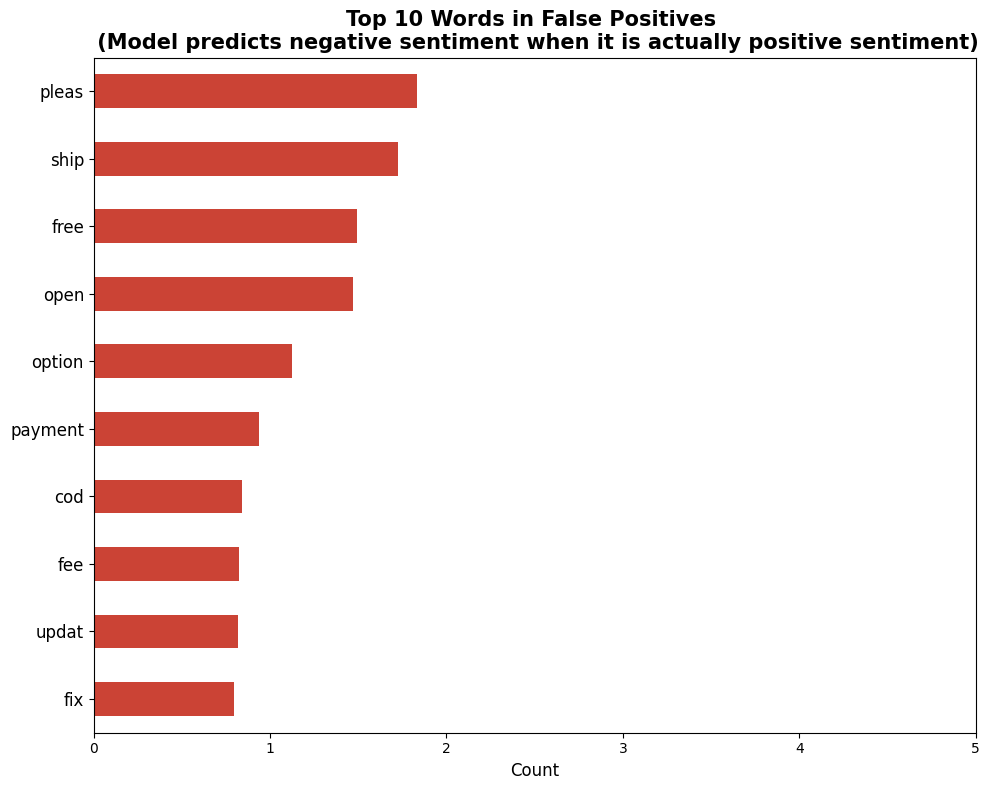

In [ ]:
# Top words seen in False Positives - Model incorrectly predicts these as negative sentiment when they are actually positive sentiment
barplot_tvec(df=test,
             pred=1,
             title="Top 10 Words in False Positives \n (Model predicts negative sentiment when it is actually positive sentiment)",
             color='#CB4335')

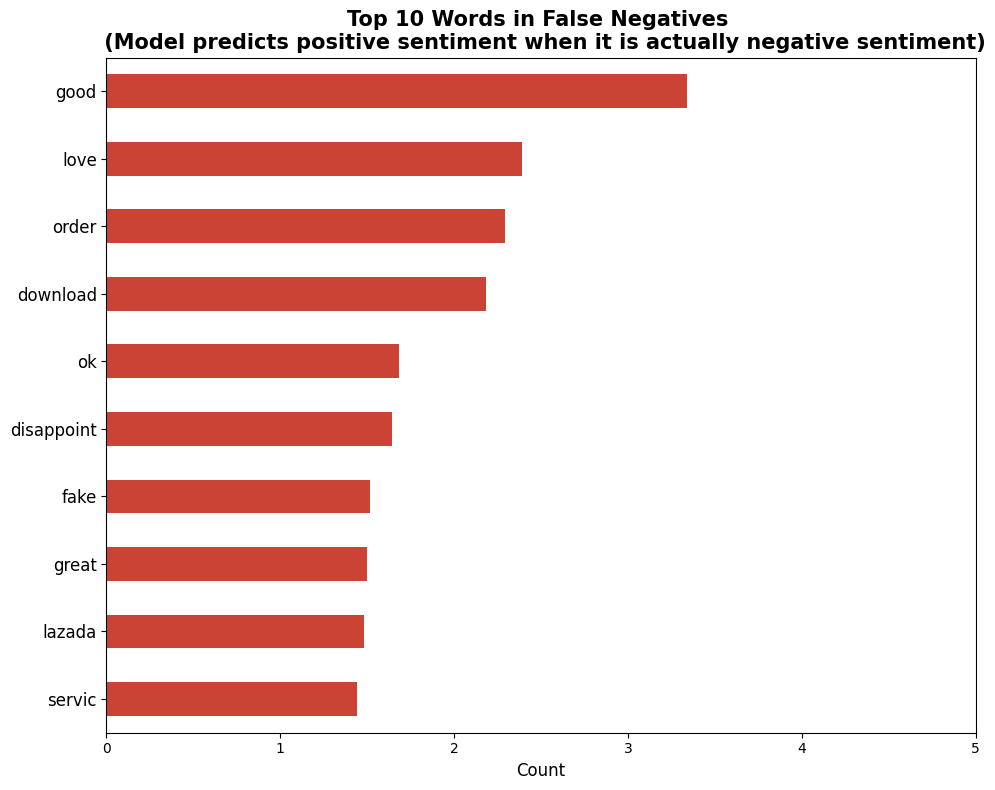

In [ ]:
# Top words seen in False Negatives - Model incorrectly predicts these as postive sentiment when they are actually negative sentiment
barplot_tvec(df=test,
             pred=0,
             title="Top 10 Words in False Negatives \n (Model predicts positive sentiment when it is actually negative sentiment)",
             color='#CB4335')

In [ ]:
# False Negatives
fn = test[(test['correctly_classified']==0) & (test['pred']==0)][['review_text','content_stem','review_rating']]

In [ ]:
# Count the number of times the word 'good' appears in the review
fn['count_good'] = fn['content_stem'].str.count('good')

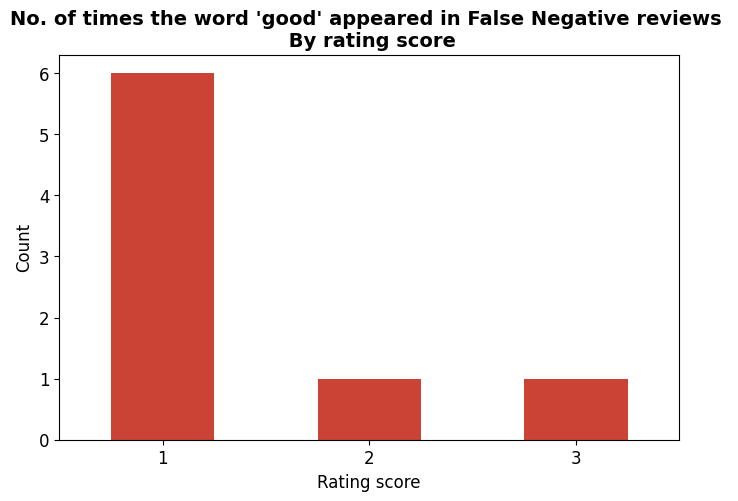

In [ ]:
plt.figure(figsize=(8,5))

# Group False Negative reviews by their ratings and sum up the no. of times the word 'good' was seen
fn.groupby('review_rating')['count_good'].sum().plot(kind='bar', color='#CB4335')

plt.title("No. of times the word 'good' appeared in False Negative reviews \n By rating score", size=14, weight='bold')
plt.ylabel("Count", size=12)
plt.yticks(size=12)
plt.xlabel("Rating score", size=12)
plt.xticks(size=12, rotation=0);

In [ ]:
# View only the False Negatives that has the words 'good' in it
fn[fn['count_good']>0][['review_text','content_stem','review_rating']].sort_values(by='review_rating')

,review_text,content_stem,review_rating
129,it is good because the items are affordable,good afford,1
232,good shopee,good,1
549,good products but very expensive charges than lazada,good product expens charg lazada,1
578,"this is my views and opinion using shoppee and i feel disappointment using this app because when i reviewed my order and not really satisfied with my order, i tried to tell the truths and share it to everyone. i am not using bad words and i only stated the quality of the products if it's good or not or not good for its price but this app hide my reviews and take back the coins that i got in reviewing of my order. i felt that shopee will never listen to the opinion of the customers 😃",view opinion use feel disappoint use review order realli satisfi order tri tell truth share everyon use word state qualiti product good good price hide review take back coin got review order felt never listen opinion custom,1
594,not good,good,1
158,"i used to buy anything what i need from shopee because they offer lot of good deals. plus you can add 2 voucher at the same time. but now you can either just choose cashback or fsv, i am so disappointed with this new update. as someone, i need to save as much as i can. now i am looking onto different shopping app.",use buy anyth need offer lot good deal plu add voucher time either choos cashback fsv disappoint new updat someon need save much look onto differ shop,2
744,goodnin terms of items but in terms of quality of service? shopee itself... #poor,goodnin term term qualiti servic poor,3


<h1><b> Topic Modeling for Negative Sentiment</b></h1>

Use Gensim's LDA to identify the key pain points that dissatisfied customers are facing.

Before running LDA, we will first perform a simple pre-processing by removing stopwords, lemmatizing and using SpaCy to only keep tokens that are nouns, adjectives, verbs or adverbs. This approach gave us more distinct topics than if we were to just rely on the same pre-processing approach as that used during classification modeling.

In [ ]:
# Create a list of all the textual data from negative reviews
data = reviews[reviews['target']==1]['review_text'].values.tolist()

In [ ]:
# Load Filipino stopwords from a .txt file taken from
# https://github.com/explosion/spaCy/blob/master/spacy/lang/tl/stop_words.py and
# https://github.com/stopwords-iso/stopwords-tl

# Initialize an empty list for Filipino stopwords
filipino_stopwords = []

# Load Filipino stopwords from the first .txt file
with open('genediazjr-tagalog.txt', 'r', encoding='utf-8') as file1:
    filipino_stopwords.extend([line.strip() for line in file1])

# Load Filipino stopwords from the second .txt file
with open('stopwords-tl.txt', 'r', encoding='utf-8') as file2:
    filipino_stopwords.extend([line.strip() for line in file2])

print(filipino_stopwords)

['ako', 'sa', 'akin', 'ko', 'aking', 'sarili', 'kami', 'atin', 'ang', 'aming', 'amin', 'ating', 'ka', 'iyong', 'iyo', 'inyong', 'siya', 'kanya', 'mismo', 'ito', 'nito', 'kanyang', 'sila', 'nila', 'kanila', 'kanilang', 'kung', 'ano', 'alin', 'sino', 'kanino', 'na', 'mga', 'iyon', 'am', 'ay', 'maging', 'naging', 'mayroon', 'may', 'nagkaroon', 'pagkakaroon', 'gumawa', 'ginagawa', 'ginawa', 'paggawa', 'ibig', 'dapat', 'maaari', 'marapat', 'kong', 'ikaw', 'tayo', 'hindi', 'namin', 'gusto', 'nais', 'niyang', 'nilang', 'niya', 'huwag', 'ginawang', 'gagawin', 'maaaring', 'sabihin', 'narito', 'kapag', 'ni', 'nasaan', 'bakit', 'paano', 'kailangan', 'walang', 'katiyakan', 'isang', 'at', 'pero', 'o', 'dahil', 'bilang', 'hanggang', 'habang', 'ng', 'pamamagitan', 'para', 'tungkol', 'laban', 'pagitan', 'panahon', 'bago', 'pagkatapos', 'itaas', 'ibaba', 'mula', 'pataas', 'pababa', 'palabas', 'ibabaw', 'ilalim', 'muli', 'pa', 'minsan', 'dito', 'doon', 'saan', 'lahat', 'anumang', 'kapwa', 'bawat', 'ilan

In [ ]:
# Assign NLTK's stopwords to stop_words
english_stopwords = set(stopwords.words('english'))

# Merge English and Filipino stopwords into one list
stop_words = english_stopwords.union(filipino_stopwords)

# Include frequently occuring words like 'app' and 'shopee' to the stopwords list. These words will not value add to our topics.
stop_words.update(['app','shopee','shoppee','item','items','seller','sellers','bad', 'yung', 'lang', 'nyo', 'naman', 'di'])

In [ ]:
!python -m spacy download en_core_web_lg
!python -m spacy download en_core_web_sm

                                              0.0/587.7 MB ? eta -:--:--
                                              0.1/587.7 MB 1.7 MB/s eta 0:05:38
                                              0.1/587.7 MB 1.4 MB/s eta 0:06:55
                                              0.3/587.7 MB 1.8 MB/s eta 0:05:22
                                              0.4/587.7 MB 2.1 MB/s eta 0:04:43
                                              0.5/587.7 MB 2.2 MB/s eta 0:04:24
                                              0.7/587.7 MB 2.6 MB/s eta 0:03:44
                                              0.9/587.7 MB 3.0 MB/s eta 0:03:19
                                              1.1/587.7 MB 2.8 MB/s eta 0:03:31
                                              1.3/587.7 MB 3.0 MB/s eta 0:03:17
                                              1.4/587.7 MB 3.1 MB/s eta 0:03:07
                                              1.6/587.7 MB 3.1 MB/s eta 0:03:09
                                              1

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\Kismet Suan\AppData\Local\Programs\Python\Python310\lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\Kismet Suan\AppData\Local\Programs\Python\Python310\lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
  File "C:\Users\Kismet Suan\AppData\Local\Programs\Python\Python310\lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
  File "C:\Users\Kismet Suan\AppData\Local\Programs\Python\Python310\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 90, in read
    data = self.__fp.read(amt)
  File "C:\Users\Kismet Suan\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 465, in read
    s = self.fp.read(amt)
  File "C:\Users\Kismet Suan\AppData\Local\Programs\Python\Python310\

     -------                                121.4/587.7 MB 2.3 MB/s eta 0:03:23
     -------                                121.5/587.7 MB 2.3 MB/s eta 0:03:23
     -------                                121.8/587.7 MB 2.3 MB/s eta 0:03:20
     -------                                122.0/587.7 MB 2.3 MB/s eta 0:03:20
     -------                                122.2/587.7 MB 2.4 MB/s eta 0:03:17
     -------                                122.3/587.7 MB 2.4 MB/s eta 0:03:15
     -------                                122.6/587.7 MB 2.4 MB/s eta 0:03:14
     -------                                122.7/587.7 MB 2.4 MB/s eta 0:03:16
     -------                                122.9/587.7 MB 2.4 MB/s eta 0:03:15
     -------                                123.0/587.7 MB 2.4 MB/s eta 0:03:14
     -------                                123.1/587.7 MB 2.4 MB/s eta 0:03:15
     -------                                123.2/587.7 MB 2.4 MB/s eta 0:03:14
     -------                            


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



                                              0.0/12.8 MB ? eta -:--:--
                                              0.1/12.8 MB 2.6 MB/s eta 0:00:05
                                              0.2/12.8 MB 1.8 MB/s eta 0:00:07
                                              0.3/12.8 MB 2.5 MB/s eta 0:00:06
     -                                        0.5/12.8 MB 2.7 MB/s eta 0:00:05
     -                                        0.6/12.8 MB 2.6 MB/s eta 0:00:05
     --                                       0.8/12.8 MB 2.7 MB/s eta 0:00:05
     --                                       0.9/12.8 MB 2.8 MB/s eta 0:00:05
     ---                                      1.1/12.8 MB 3.0 MB/s eta 0:00:04
     ---                                      1.2/12.8 MB 2.8 MB/s eta 0:00:05
     ---                                      1.3/12.8 MB 2.7 MB/s eta 0:00:05
     ----                                     1.3/12.8 MB 2.6 MB/s eta 0:00:05
     ----                                     1.4/12.8 MB 

In [ ]:
# Remove stopwords, lemmatize and only keep tokens that fall into these part of speech tags
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):

    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent))
        # Lemmatize and only keep tokens that have certain part of speech tags
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # Remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

# Pre-processing text
data_ready = process_words(data)

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, # Number of topics
                                           random_state=42,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.031*"update" + 0.023*"fix" + 0.021*"slow" + 0.021*"always" + '
  '0.020*"product" + 0.019*"service" + 0.018*"need" + 0.016*"thing" + '
  '0.015*"open" + 0.013*"customer"'),
 (1,
  '0.053*"voucher" + 0.049*"shipping" + 0.029*"free" + 0.023*"day" + '
  '0.023*"good" + 0.021*"store" + 0.016*"fee" + 0.016*"back" + '
  '0.014*"available" + 0.013*"use"'),
 (2,
  '0.034*"order" + 0.024*"time" + 0.022*"delivery" + 0.021*"even" + '
  '0.020*"still" + 0.015*"use" + 0.014*"get" + 0.013*"option" + '
  '0.012*"courier" + 0.011*"cash"')]


In [ ]:
#I removed the comments to make the bloc shorter
def format_topics_sentences(corpus, texts, ldamodel=None):
    data = []

    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: x[1], reverse=True)

        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                data.append([int(topic_num), round(prop_topic, 4), topic_keywords])
            else:
                break

    sent_topics_df = (
        pd.DataFrame(data, columns=[
            'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])
                .assign(Text= texts) # or use Text= pd.Series(text)
    )

    return sent_topics_df

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
# Formatting the table
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2,0.4415,"order, time, delivery, even, still, use, get, option, courier, cash","[last, month, today, always, say, available, shipping, option, therefore, add, cart, place, order, available, shipping, option, fix, problem, customer, order]"
1,1,2,0.6913,"order, time, delivery, even, still, use, get, option, courier, cash","[restrict, disappoint]"
2,2,1,0.9316,"voucher, shipping, free, day, good, store, fee, back, available, use","[minimum, spend, free, shipping, area, charge, ship, fee, talaga]"
3,3,1,0.5530,"voucher, shipping, free, day, good, store, fee, back, available, use",[superlike]
4,4,0,0.4673,"update, fix, slow, always, product, service, need, thing, open, customer","[place, need, need, order]"


In [ ]:
# Keywords of each dominant topic
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show the 3 topics
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9616,"update, fix, slow, always, product, service, need, thing, open, customer","[fix, bug, keep, say, reload, picture, show, search, product, go, shop, say, delete, shop, goodness, update, annoying]"
1,1,0.9712,"voucher, shipping, free, day, good, store, fee, back, available, use","[policy, change, lot, start, use, get, free, shipping, voucher, everyday, eventually, free, shipping, voucher, available, special, event, sale, say, free, shipping, voucher, minimum, spend, free, shipping, voucher, available, start, sale, mn, rest, minimum, spend, pang, masa]"
2,2,0.9623,"order, time, delivery, even, still, use, get, option, courier, cash","[place, order, create, many, account, follow, instruction, still, order, pick, weither, cod, pay, use, gcash, hide, automatically, work]"


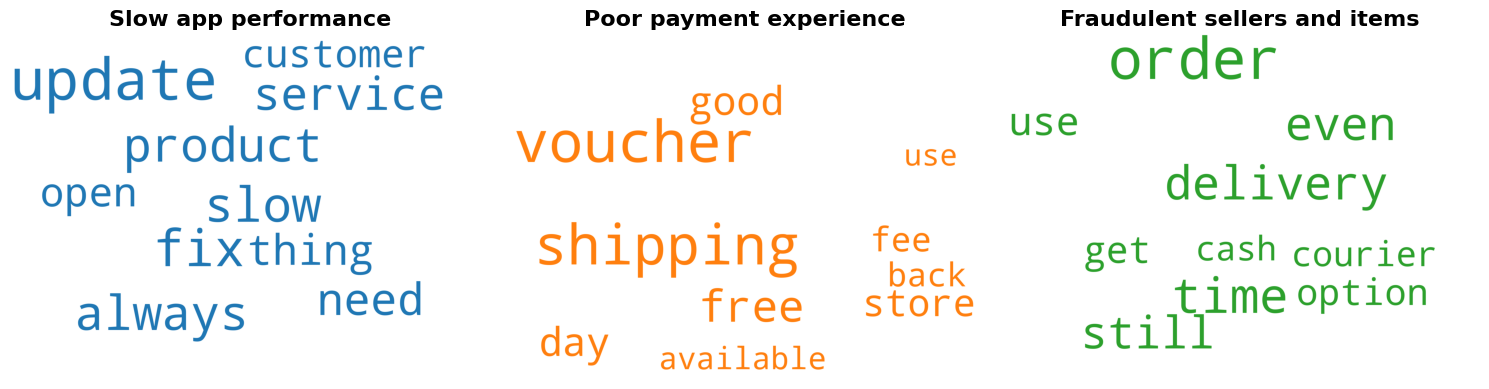

In [ ]:
# Wordcloud of Top 10 words in each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(15,10), sharex=True, sharey=True)

topic_names = ['Slow app performance', 'Poor payment experience', 'Fraudulent sellers and items']

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(topic_names[i], weight='bold', fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
# Visualisation of the topics estimated using LDA
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.177678 -0.118701       1        1  41.547880
0     -0.195336 -0.089178       2        1  29.388355
1      0.017658  0.207879       3        1  29.063765, topic_info=         Term       Freq      Total Category  logprob  loglift
133   voucher  94.000000  94.000000  Default  30.0000  30.0000
13   shipping  88.000000  88.000000  Default  29.0000  29.0000
9       order  87.000000  87.000000  Default  28.0000  28.0000
21       free  51.000000  51.000000  Default  27.0000  27.0000
148      time  61.000000  61.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
160       bug  15.330232  20.189752   Topic3  -4.7594   0.9603
30       fine   8.565736   9.919888   Topic3  -5.3414   1.0889
130       use  22.853358  61.596181   Topic3  -4.3601   0.2442
126    really  15.712979  32.280921   Topic3  -4.7347   0.5157
187    update  13.369434  68.985978   Topic3  -4.8962  -0.4053

[138 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
259       1  0.979068  account
0         2  0.942871      add
110       1  0.965147  already
428       1  0.968800     also
1         2  0.981876   always
...     ...       ...      ...
133       3  0.992767  voucher
97        1  0.959174     want
134       1  0.980875     work
568       1  0.980049    wrong
568       2  0.039202    wrong

[142 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [ ]:
# Browse through the reviews that contain the top words related to each topic
reviews[(reviews['target']==1) & (reviews['review_text'].str.contains('payment'))]['review_text']

101                                                                                                                                                                                                                                                                                                                                                                                                         shopee i can't cash in. my spaylater is now skyrocketing with late fees plus your e-payment has admin fee 😡😡😡🤬
606                                                              1st time to buy at shopee, on payment details, i inputted my cc details and verified with bpi otp code, but the app suddendly froze and now i don't know what happened to the transaction. no other details in my account. this is frustrating as i'm not sure now whether i was charged or not, will have to wait for monday so i can call my bank and shopee since their consumer hotline is not available 24/7. lazada app is way better.

In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import pickle

# Read the clean dataset
reviews = pd.read_csv('clean_train2.csv')

X = reviews['content_stem']
y = reviews['target']

# Perform train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create a pipeline with TF-IDF and Multinomial Naive Bayes
pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())  # Use Multinomial Naive Bayes here
])

# Search over the following values of hyperparameters:
pipe_tvec_nb_params = {
    'tvec__max_features': [300],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'nb__alpha': [0.1, 1]  # Add alpha for smoothing
}

# Instantiate GridSearchCV
gs_tvec_nb = GridSearchCV(pipe_tvec_nb,
                          param_grid=pipe_tvec_nb_params,
                          cv=10)

# Fit model on to training data
gs_tvec_nb.fit(X_train, y_train)

# Saving model to disk
pickle.dump(gs_tvec_nb, open('model3.pkl', 'wb'))

# Loading model to compare the results
# model = pickle.load(open('model.pkl','rb'))
# print(model.predict([[2, 9, 6]]))


In [ ]:
import pickle

# Load the model
model = pickle.load(open('model3.pkl', 'rb'))

# Example text for prediction
new_text = ["good app"]

# Make a prediction
prediction = model.predict(new_text)

# Print the prediction
print(prediction)


[0]


In [ ]:
!pip install pyngrok


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from flask import Flask, request, render_template
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import pickle
from pyngrok import ngrok  # import ngrok library

# Load the Naive Bayes model
model = pickle.load(open('model3.pkl', 'rb'))


In [ ]:
# Instantiate PorterStemmer
p_stemmer = PorterStemmer()

# Define the preprocess_text function
def preprocess_text(raw_text):
    # Remove HTML
    review_text = BeautifulSoup(raw_text, 'html.parser').get_text()

    # Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)

    # Convert words to lowercase and split each word up
    words = letters_only.lower().split()

    # Convert stopwords to a set
    stops = set(stopwords.words('english'))

    # Adding stopwords that were appearing frequently in both positive and negative reviews
    stops.update(['app', 'shopee', 'shoppee', 'item', 'items', 'seller', 'sellers', 'bad'])

    # Remove stopwords
    meaningful_words = [w for w in words if w not in stops]

    # Stem words
    meaningful_words = [p_stemmer.stem(w) for w in meaningful_words]

    # Join words back into one string, with a space in between each word
    final_text = " ".join(meaningful_words)

    return final_text

In [ ]:
# Flask app initialization
app = Flask(__name__)

# Define the predict route
@app.route('/', methods=['GET', 'POST'])
def predict():
    if request.method == 'POST':
        raw_text = request.form['review']

        # Preprocess the input text
        final_text = preprocess_text(raw_text)

        # Generate predictions
        pred = model.predict([final_text])[0]

        if pred == 1:
            output = "Negative"
        else:
            output = "Positive"

        return render_template('index.html', prediction_text='{} sentiment predicted'.format(output))

    return render_template('index.html')

# Expose the Flask app using ngrok when running in Colab
def run_ngrok():
    ngrok.kill()
    ngrok_tunnel = ngrok.connect(5000)
    print(' * Tunnel URL:', ngrok_tunnel.public_url)

# Run the Flask app
if __name__ == '__main__':
    from threading import Thread

    # Start ngrok when the app is run
    Thread(target=run_ngrok).start()

    # Start the Flask app on port 5000
    app.run(port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


[2023-12-11 04:11:52,221] ERROR in app: Exception on / [GET]
Traceback (most recent call last):
  File "C:\Users\Kismet Suan\AppData\Local\Programs\Python\Python310\lib\site-packages\flask\app.py", line 1455, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\Kismet Suan\AppData\Local\Programs\Python\Python310\lib\site-packages\flask\app.py", line 869, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\Kismet Suan\AppData\Local\Programs\Python\Python310\lib\site-packages\flask\app.py", line 867, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\Kismet Suan\AppData\Local\Programs\Python\Python310\lib\site-packages\flask\app.py", line 852, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "C:\Users\Kismet Suan\AppData\Local\Temp\ipykernel_14816\3911545099.py", line 23, in predict
    return render_template('index.html')
  File "C:\Users\Kismet Suan\AppData\Lo

 * Tunnel URL: https://a13c-49-145-168-148.ngrok.io
